# <p style="text-align: center; font-size: 30px; color:#1F70C1;">Navigating the Learning Landscape with NLP:<br>A Study on IBM Skills Build</p> 
 
## <p style="text-align: center; font-size: 24px; color:#4999e8;">Developing an NLP Tool for Matching Skills with Existing IBM Skills Build Courses</p>
 

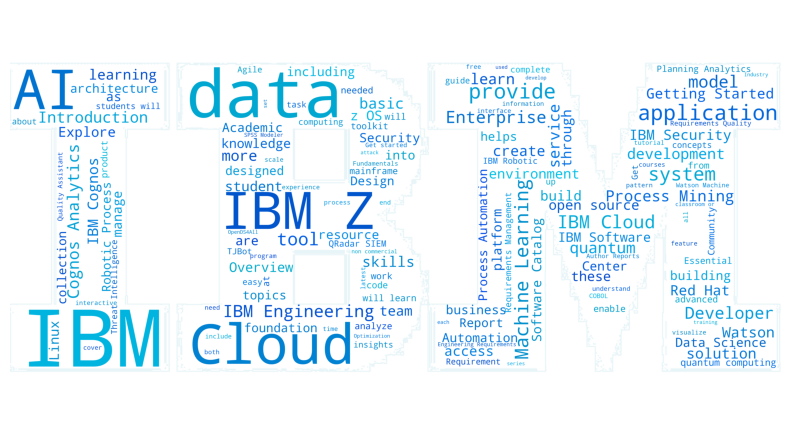

## <span style="color:#1F70C1">Content</span>

## [ <span style="color:red"> 1. To-Do First: Libraries </span>](#first)


## [ 2. Preparatory Functions ](#second)

## [ 3. Dashboard ](#third)

### <span style="color:red"> 1. To-Do First: Libraries</span></span> <a class="anchor" id="first"></a>

In [ ]:
!pip install pandas
!pip install numpy
!pip install openai
!pip install requests
!pip install panel
!pip install nltk
!pip install scikit-learn
!pip install transformers
!pip install torch
# !pip install wordcloud
# !pip install plotly.express
# !pip install plotly
# !pip install seaborn
# !python -m spacy download en_core_web_sm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import os
# import matplotlib
# import matplotlib.cm as cm
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# from matplotlib.ticker import FormatStrFormatter
# matplotlib.style.use('seaborn')
# %matplotlib inline
# plt.style.use('seaborn')
# import plotly as py
# import plotly.io as pio
# import plotly.express as px
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objects as go
# import json
# from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from IPython.display import display, clear_output, HTML, Markdown
import ipywidgets as widgets
# from ipywidgets import HBox, VBox
import textwrap
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist, euclidean
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import openai
import panel as pn  # GUI
pn.extension()
import gensim.downloader as api
nltk.download('stopwords')

# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# import time
# from selenium.common.exceptions import NoSuchElementException, TimeoutException
# from selenium.webdriver.common.action_chains import ActionChains
# import spacy
# from spacy.lang.en import English
# Load spaCy model
# nlp = spacy.load('en_core_web_sm')
# nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faculty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2. Preparatory Functions </span> <a class="anchor" id="second"></a>

In [2]:
#the below is the preprocess_glove function:

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

<span style="color:darkorange"> **I think using the preprecess_glove function (that removes stopwords for user input) (above) is better because it can make the input be more streamlined?<br><br> whereas the normal preprocess function does not remove stopwords and it is good for doing the preprocessing stage before word embedding, but since the user input might contain some extra words...** </span> 

In [3]:
# def preprocess(text):
#     # Convert to lowercase
#     text = text.lower()
    
#     # Remove punctuation
#     text = text.translate(str.maketrans('', '', string.punctuation))
    
#     # Remove numbers
#     text = re.sub(r'\d+', '', text)
    
#     # Remove extra whitespaces
#     text = re.sub(r'\s+', ' ', text).strip()
    
#     # Remove stop words
#     stop_words = set(stopwords.words('english'))
#     tokens = text.split()
#     filtered_tokens = [word for word in tokens if word not in stop_words]
#     text = ' '.join(filtered_tokens)
    
#     return text

In [4]:
def get_relevant_courses(prompt, df):
    """
    This function returns the relevant courses based on the user's input.
    """
    prompt = prompt.lower()
    relevant_courses = df[df['skill name'].str.lower().str.contains(prompt, case=False) | 
                          df['topic'].str.lower().str.contains(prompt, case=False) | 
                          df['description'].str.lower().str.contains(prompt, case=False)]
    return relevant_courses

In [5]:
# Load pre-trained model and tokenizer
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Function to calculate RoBERTa embeddings
def calculate_roberta_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(axis=1).detach().numpy()
    return embeddings[0]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Define a list to store the input history
input_history = []

def collect_messages(_):
    """
    This function collects and processes the user messages.
    """
    global input_history  # Declare the variable as global
    
    prompt = inp.value
    
    # Add the current input to the history
    input_history.append(prompt)
    
    inp.value = ''
    
    # List of phrases that are considered as thanking
    thank_you_phrases = ["thank you", "thanks", "appreciate it", "grateful", "much obliged", 
                         "cheers", "much appreciated", "thanks for the assistance"]

    # Preprocess user input
    user_input_processed = preprocess(prompt)

    # Check if the user_input_processed is in the list of thank you phrases. If it is, say 'you're welcome'
    if any(word in user_input_processed.lower() for word in thank_you_phrases):
        response = "You're welcome! I hope you find them useful in your learning journey!"
        
    # Initial check for input prompt
    elif not prompt.strip():
        response = "Welcome to IBM Skills Build!\nWhat would you like to learn more about?"
    
    else:
        # Check for direct matches in the dataset
        relevant_courses = get_relevant_courses(user_input_processed, df_final)
        
        # Generate the chatbot response based on direct matches
        if not relevant_courses.empty:
            response = generate_direct_matches_response(relevant_courses)
        
        else:
            # Calculate user embedding
            user_embedding = calculate_roberta_embedding(user_input_processed)

            if np.isnan(user_embedding).any():
                response = "Sorry, I couldn't understand your input. Please try again."
            else:
                # Calculate Euclidean distance between user input embedding and row embeddings
                topic_distance = cdist(df_final[[f"embedding_topic_{i}" for i in range(768)]], [user_embedding], metric='euclidean')
                type_distance = cdist(df_final[[f"embedding_type_{i}" for i in range(768)]], [user_embedding], metric='euclidean')
                skill_distance = cdist(df_final[[f"embedding_skill_{i}" for i in range(768)]], [user_embedding], metric='euclidean')
                description_distance = cdist(df_final[[f"embedding_description_{i}" for i in range(768)]], [user_embedding], metric='euclidean')

                # Combine distance scores (take the negative because we want to sort in descending order later)
                total_distance = -(topic_distance + type_distance + skill_distance + description_distance)

                # Retrieve most similar rows based on similarity scores
                top_indices = total_distance.argsort(axis=0)[-10:][::-1]  # Retrieve top 10 matches in descending order

                # Generate the chatbot response
                response = generate_similarity_response(top_indices, df_final)

    # Append the "User" row only when there is a non-empty prompt
    if prompt.strip():
        panels.append(pn.Row('User:', pn.pane.Markdown(prompt, width=800)))
    
    panels.append(
        pn.Row('Assistant:', pn.pane.HTML(response, width=800, style={'background-color': '#e8f5f8'})))
    return pn.Column(*panels)


def generate_similarity_response(top_indices, df_final, max_responses=10):
    """
    Generates the chatbot response for the input that doesn't directly match something in the dataset, based on similarity scores.
    """
    response = "Based on your interests, here are the top 10 skills we think you'll find useful:<br>Click (opens in new tab) on the skill name or the course name for the relevant IBM Skilld Build website!<br><br>"
    num_responses = min(max_responses, len(top_indices.flatten()))
    print("5")
    for i, idx in enumerate(top_indices.flatten(), 1):
        topic = df_final.loc[idx]['topic']
        skill_name = df_final.loc[idx]['skill name']
        link = df_final.loc[idx]['link']
        type_ = df_final.loc[idx]['type']
        description = df_final.loc[idx]['description']
        specific_link = df_final.loc[idx]['specific link']

        response += f'{i}. <a href="{link}" target="_blank">{topic}</a> - <a href="{specific_link}" target="_blank">{skill_name}</a> ({type_}):'
        response += f'   {description}<br><br>'
    return response


def generate_direct_matches_response(relevant_courses, max_responses=10):
    """
    Generates the chatbot response for the directly matched courses.
    """
    response = "Based on your interests, here are some relevant courses we think you'll find useful:<br> Click (opens in new tab) on the skill name or the course name for the relevant IBM Skilld Build website!<br><br>"
    
    num_responses = min(max_responses, len(relevant_courses))
    for i, course in enumerate(relevant_courses.iterrows(), 1):
        if i > num_responses:
            break
        topic = course[1]['topic']
        skill_name = course[1]['skill name']
        link = course[1]['link']
        type_ = course[1]['type']
        description = course[1]['description']
        specific_link = course[1]['specific link']

        response += f"{i}. <a href='{link}' target='_blank'>{topic}</a> - <a href='{specific_link}' target='_blank'>{skill_name}</a> ({type_}):"
        response += f"   {description}<br><br>"
    return response



### 3. Q&A Dashboard </span> <a class="anchor" id="third"></a>

In [7]:
# Load the CSV file
df_final = pd.read_csv('FINAL (processed roberta embedded).csv')

pn.extension() #panel extension

panels = [] # collect display 
inp = pn.widgets.TextInput(placeholder='Enter a skill...')

# Initialize "Chat!" button 
button_conversation = pn.widgets.Button(name="Chat!")

interactive_conversation = pn.bind(collect_messages, button_conversation)

dashboard = pn.Column(
    inp,                             #input box
    pn.Row(button_conversation),     #followed by the button "Chat!" 
    pn.panel(interactive_conversation, loading_indicator=True, height=400)    #styling
)

dashboard

Column
    [0] TextInput(placeholder='Enter a skill...')
    [1] Row
        [0] Button(name='Chat!')
    [2] ParamFunction(function, height=400, loading_indicator=True)